## Introduction

In this study project, the tensorflow hub is used, TensorFlow Hub is a library to foster the publication, discovery, and consumption of reusable parts of machine learning models. In particular, it provides modules, which are pre-trained pieces of TensorFlow models that can be reused on new tasks.


### Dependencies

- Tensorflow
- Tensorflow_hub
- matplotlib
- tempfile : for creating temporary directories
- Pillow : for some image processing
- numpy
- time : for measuring inference time
- Jupyter notebook or Google's Colaboratory

In [0]:
# For drawing onto the image.
import numpy as np
import matplotlib.pyplot as plt

# For temporary directories
import tempfile
# For downloading the image.
from six.moves.urllib.request import urlopen

#BytesIO can be used like a file opened in binary mode
from six import BytesIO


#python image library
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps
import time

import tensorflow as tf
import tensorflow_hub as hub

In [0]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

In [0]:
def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

In [0]:
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)
  
  
  
  
  
  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = bottom + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin
    

In [0]:
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i].tolist())
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

In [6]:
image_url = "https://farm1.staticflickr.com/4032/4653948754_c0d768086b_o.jpg"
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

Output hidden; open in https://colab.research.google.com to view.

Found 100 objects.


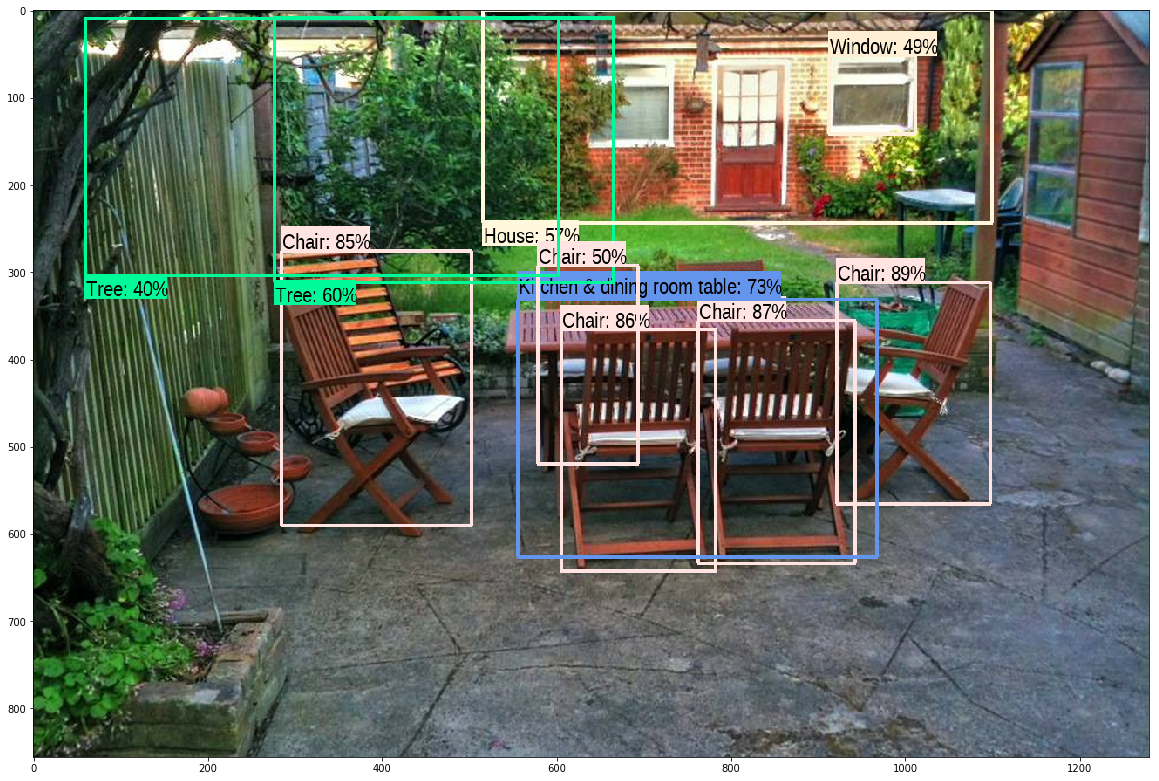

In [7]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

with tf.Graph().as_default():
  detector = hub.Module(module_handle)
  image_string_placeholder = tf.placeholder(tf.string)
  decoded_image = tf.image.decode_jpeg(image_string_placeholder)
  # Module accepts as input tensors of shape [1, height, width, 3], i.e. batch
  # of size 1 and type tf.float32.
  decoded_image_float = tf.image.convert_image_dtype(
      image=decoded_image, dtype=tf.float32)
  module_input = tf.expand_dims(decoded_image_float, 0)
  result = detector(module_input, as_dict=True)
  init_ops = [tf.global_variables_initializer(), tf.tables_initializer()]

  session = tf.Session()
  session.run(init_ops)

  # Load the downloaded and resized image and feed into the graph.
  with tf.gfile.Open(downloaded_image_path, "rb") as binfile:
    image_string = binfile.read()

  result_out, image_out = session.run(
      [result, decoded_image],
      feed_dict={image_string_placeholder: image_string})
  print("Found %d objects." % len(result_out["detection_scores"]))

image_with_boxes = draw_boxes(
    np.array(image_out), result_out["detection_boxes"],
    result_out["detection_class_entities"], result_out["detection_scores"])

display_image(image_with_boxes)

In [8]:
image_urls = ["https://farm7.staticflickr.com/8092/8592917784_4759d3088b_o.jpg",
              "https://farm6.staticflickr.com/2598/4138342721_06f6e177f3_o.jpg",
              "https://c4.staticflickr.com/9/8322/8053836633_6dc507f090_o.jpg"]

for image_url in image_urls:
  image_path = download_and_resize_image(image_url, 640, 480)
  with tf.gfile.Open(image_path, "rb") as binfile:
    image_string = binfile.read()

  inference_start_time = time.clock()
  result_out, image_out = session.run(
      [result, decoded_image],
      feed_dict={image_string_placeholder: image_string})
  print("Found %d objects." % len(result_out["detection_scores"]))
  print("Inference took %.2f seconds." % (time.clock()-inference_start_time))

  image_with_boxes = draw_boxes(
    np.array(image_out), result_out["detection_boxes"],
    result_out["detection_class_entities"], result_out["detection_scores"])

  display_image(image_with_boxes)

Output hidden; open in https://colab.research.google.com to view.